<a href="https://colab.research.google.com/github/jeongwoo22/ESAA_assignments/blob/main/%EA%B3%BC%EC%A0%9C20_1209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 위성 이미지 분류

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

import tensorflow_datasets as tfds


## 데이터 로드

In [2]:
#데이터 셋 로드

DATA_DIR = "dataset/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split = ['train[:80%]', 'train[80%:]'],
                                                               shuffle_files = True,
                                                               as_supervised = True,
                                                               with_info = True,
                                                               data_dir = DATA_DIR)

print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incomplete7MF1UE/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

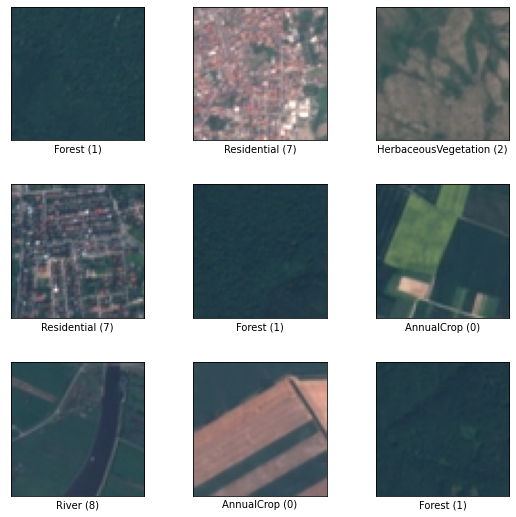

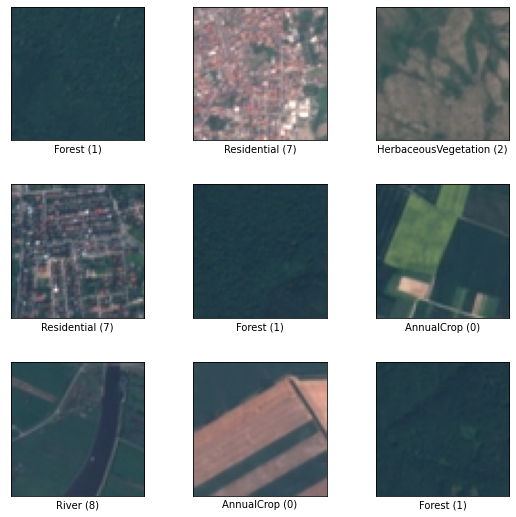

In [4]:
#데이터 확인

tfds.show_examples(train_ds,info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

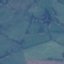
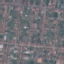
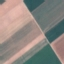
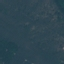
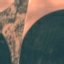
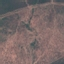
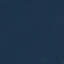
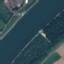
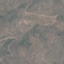
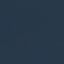

In [5]:
tfds.as_dataframe(valid_ds.take(10),info)

In [6]:
#목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [7]:
#숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


## 데이터 전처리

In [8]:
BATCH_SIZE= 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    #정규화, float32 변환
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls= tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## 모델 훈련

In [9]:
def build_model() :
  model = tf.keras.Sequential([
      
      #Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

  ])
  return model

model = build_model()

In [11]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_data, validation_data = valid_data, epochs = 1)
     

338/338 [==============================] - 191s 564ms/step - loss: 1.4075 - accuracy: 0.5023 - val_loss: 1.0773 - val_accuracy: 0.6589


In [12]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

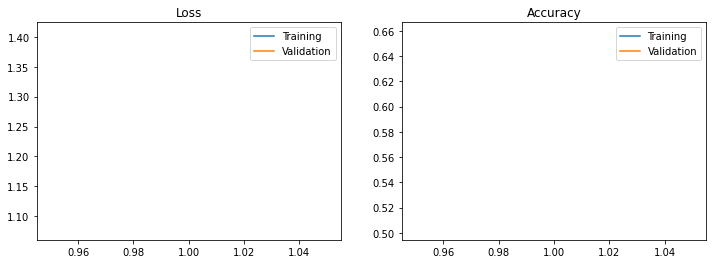

In [14]:
plot_loss_acc(history,1)

## 데이터 증강

Text(0.5, 1.0, 'SeaLake')

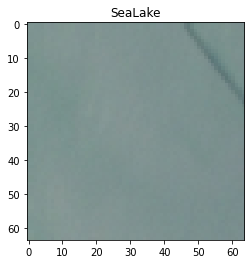

In [15]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [16]:
#데이터 증강 전후비교

def plot_augmentation(original, augmented) :
  fig,axes = plt.subplots(1,2, figsize = (12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')
  
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

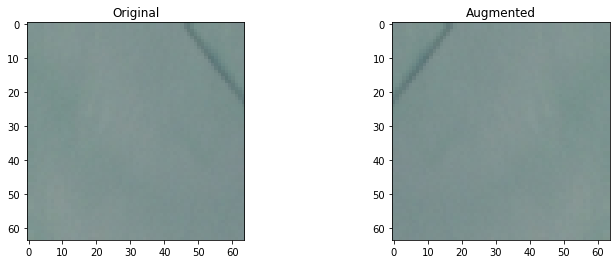

In [17]:
#좌우 뒤집기

lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image,lr_flip)


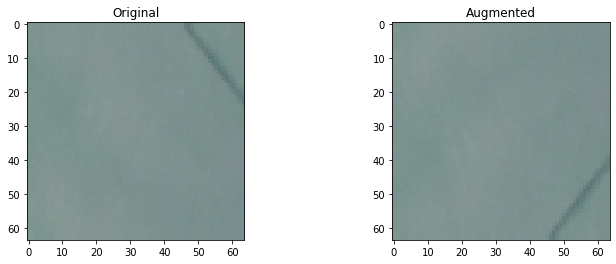

In [18]:
#상하뒤집기

ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

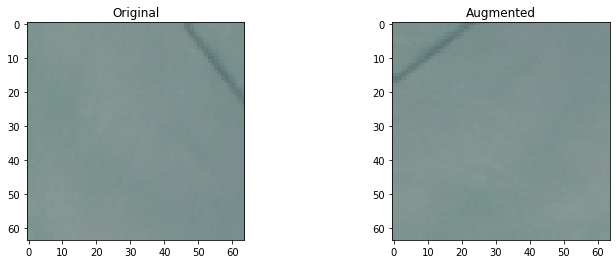

In [19]:
#반시계 방향 90도 회전

rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

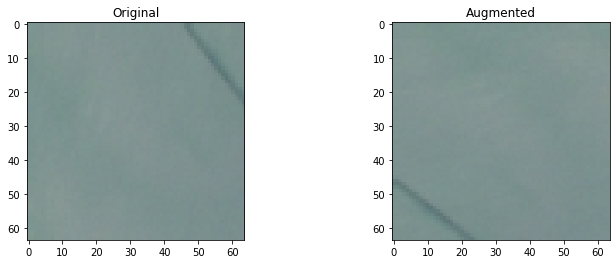

In [20]:

#행렬의 도치 Transpose

transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

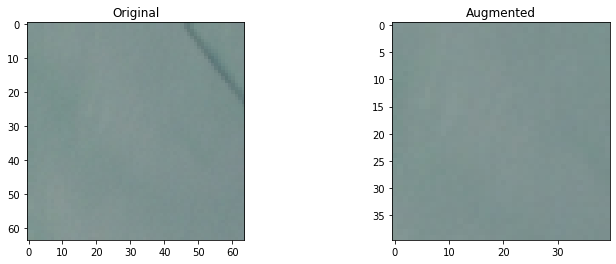

In [21]:
#이미지 자르기
crop1 = tf.image.central_crop(image,central_fraction = 0.6)
plot_augmentation(image, crop1)

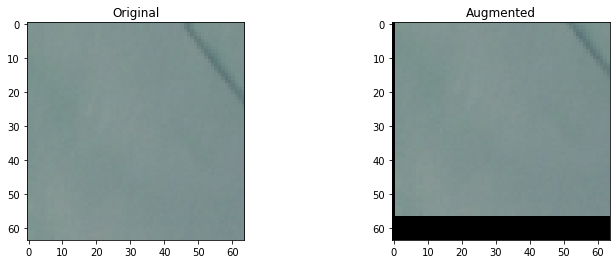

In [22]:
#원본 이미지의 크기를 키우고 이미지를 원본 크기와 같게 자르면 이미지가 랜덤한 방향으로 시프트 

img = tf.image.resize_with_crop_or_pad(image, 64+20,64+20)
crop2 = tf.image.random_crop(img,size = [64,64,3])
plot_augmentation(image, crop2)

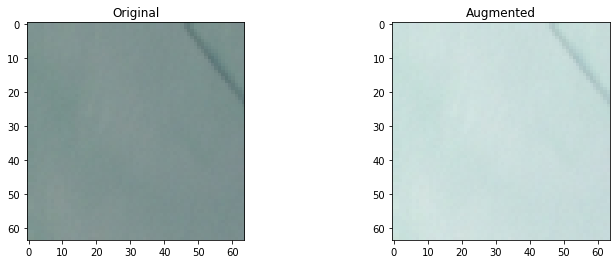

In [23]:
#이미지 밝기 조정
brightness = tf.image.adjust_brightness(image, delta = 0.3)
plot_augmentation(image, brightness)
     

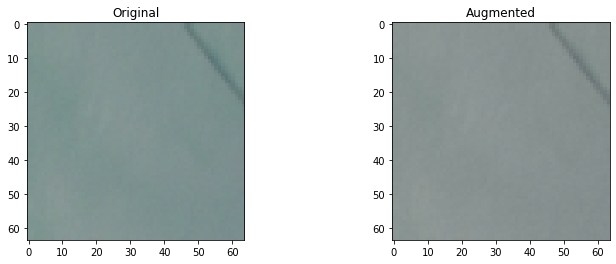

In [24]:
#이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor = 0.5)
plot_augmentation(image, saturation)

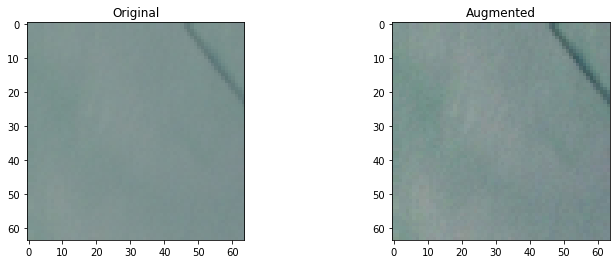

In [25]:
#이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor = 2)
plot_augmentation(image, contrast)

In [26]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
